In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy
import requests 
import os 
import datetime
from scipy import stats
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap

In [2]:
stn_coord=pd.read_csv('../data/observation/coords.csv')
stn=stn_coord['stn']
stn_lat=stn_coord['lat']
stn_lon=stn_coord['lon']

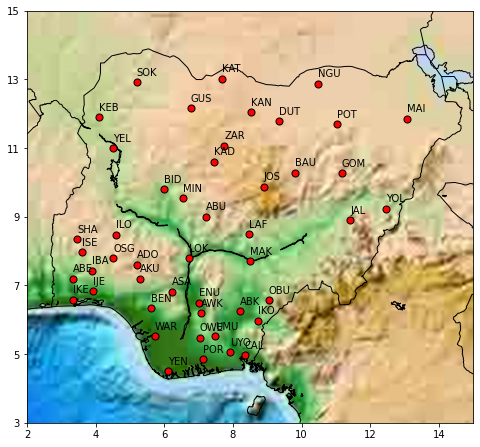

In [3]:
# ploting study area and stations location

fig=plt.figure(figsize=(8, 8))
m=Basemap(projection='cyl', resolution='h',llcrnrlat=3, urcrnrlat=15, llcrnrlon=2, urcrnrlon=15)
m.etopo(scale=5)
m.drawcoastlines(linewidth=1, color='black', zorder=2)
m.drawcountries(linewidth=1, color='black', zorder=3)

m.scatter(stn_lon, stn_lat, latlon=True, c='red', s=50, edgecolors='black', zorder=3, cmap='jet')

for i in range(len(stn_lat)):
    plt.annotate(stn[i], (stn_lon[i], stn_lat[i]+0.2))
# Map (long, lat) to (x, y) for plotting
#  x, y = m(-122.3, 47.6)
#  plt.plot(x, y, 'ok', markersize=5)
#  plt.text(x, y, ' Seattle', fontsize=12);
plt.xticks(range(2, 16, 2))
plt.yticks(range(3, 16, 2))

plt.savefig('../plots/study.png', dpi=150)

In [4]:
# Daily visibility data for 47 stations in Nigeria from Dec 2021 to Mar 2022
vis=pd.read_csv('../data/observation/vis_12_2021_03_2022.csv', index_col=[0])
vis.index=pd.to_datetime(vis.index, format='%d/%m/%Y')
# vis

In [5]:
# cap visibility maximum to 10km
# training set from Dec 2021 to Jan 2022, possible to add Feb?, validation for Mar??
vis.columns
for i in vis.columns:
    vis[i]=np.where(vis[i]>10, 10, vis[i])
vis_train=vis.iloc[:90]
vis_test=vis.iloc[90:]
vis

,ABK,ABE,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YOL,ZAR,YEN
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,NaN,10.0,10.0,10.0,6.0,10.0,5.3,10.0,8.0,10.0
2021-12-02,10.0,10.0,10.0,10.0,8.0,10.0,10.0,1.5,10.0,10.0,...,NaN,10.0,7.0,NaN,10.0,10.0,10.0,1.0,3.0,NaN
2021-12-03,10.0,10.0,3.0,10.0,10.0,10.0,10.0,1.0,10.0,1.0,...,NaN,10.0,3.0,10.0,7.0,10.0,1.5,1.6,1.0,10.0
2021-12-04,8.0,10.0,5.0,4.5,8.0,8.0,8.0,6.0,6.0,1.0,...,NaN,10.0,4.0,8.0,8.0,10.0,1.5,2.0,2.0,10.0
2021-12-05,7.0,8.0,4.0,3.0,5.0,8.0,8.0,8.0,7.0,1.0,...,NaN,2.5,10.0,7.0,3.0,NaN,3.5,5.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27,10.0,10.0,4.0,10.0,10.0,8.0,10.0,1.2,10.0,2.0,...,1.5,10.0,0.8,8.0,10.0,10.0,2.0,2.0,0.8,10.0
2022-03-28,10.0,10.0,5.0,5.0,10.0,7.0,10.0,1.0,10.0,1.5,...,0.7,10.0,1.3,7.0,10.0,10.0,2.5,1.2,0.6,10.0
2022-03-29,10.0,10.0,4.0,4.0,10.0,7.0,10.0,1.8,10.0,3.0,...,2.5,10.0,1.5,10.0,10.0,10.0,2.0,1.2,0.8,10.0


In [6]:
vis_train['KAN'].describe()

count    88.000000
mean      5.244318
std       3.443663
min       0.300000
25%       1.725000
50%       5.500000
75%       8.000000
max      10.000000
Name: KAN, dtype: float64

In [7]:
missing_train=np.isnan(vis_train).sum()
missing_test=np.isnan(vis_test).sum()
# print(missing_test)
# print(missing_train)

name=missing_train.index
print(name)
print(len(name))

Index(['ABK', 'ABE', 'ABU', 'ADO', 'AKU', 'ASA', 'AWK', 'BAU', 'BEN', 'BID',
       'CAL', 'DUT', 'ENU', 'GOM', 'GUS', 'IBA', 'IJE', 'IKE', 'IKO', 'ILO',
       'ISE', 'JAL', 'JOS', 'KAD', 'KAN', 'KAT', 'KEB', 'LAF', 'LOK', 'MAI',
       'MAK', 'MIN', 'NGU', 'OBU', 'OSG', 'OWE', 'POR', 'POT', 'SHA', 'SOK',
       'UMU', 'UYO', 'WAR', 'YEL', 'YOL', 'ZAR', 'YEN'],
      dtype='object')
47


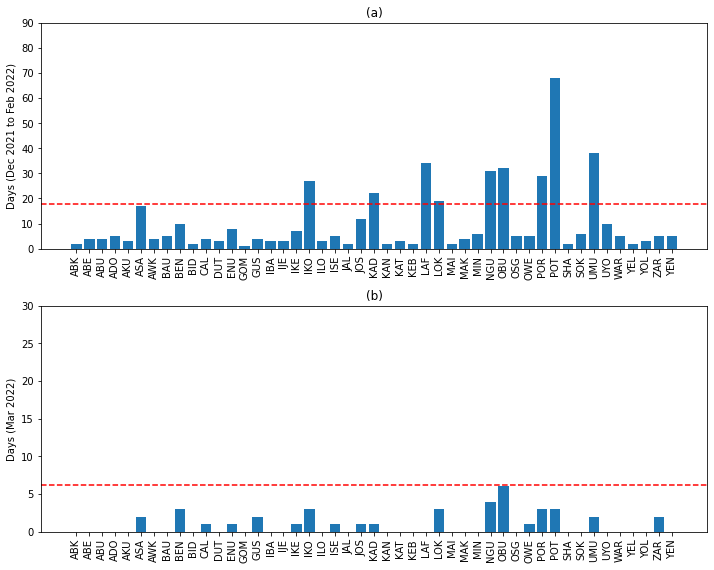

In [8]:
# plotting missing values for each station, the red line shows position of 20% missing values
bar_width=0.25
fig, (ax1, ax2) =plt.subplots(2, figsize=(10,8))

ax1.bar(name, missing_train)
ax1.set_title('(a)')
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_ylim([0,90])
ax1.axhline(y=(len(vis_train)/100)*20, color='r', linestyle='--')
ax1.set_ylabel('Days (Dec 2021 to Feb 2022)')

ax2.bar(name, missing_test)
ax2.set_title('(b)')
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_ylim([0,30])
ax2.axhline(y=(len(vis_test)/100)*20, color='r', linestyle='--')
ax2.set_ylabel('Days (Mar 2022)')

fig.tight_layout(pad=1)

fig.savefig('../plots/missing_data.png', dpi=150)

In [9]:
# bsc=xr.open_dataset('../data/models/ALADIN_DUST/2021120100_3H_ALADIN_DUST.nc')
# bsc

In [10]:
# all_models=['ALADIN_DUST', 
# all_variables=['od550_dust'
all_day1_lead=[('a', 'ALADIN_DUST', 'od550_dust', (11, 19)),
               ('b', 'BSC_DREAM8b_V2', 'OD550_DUST', (7, 15)),
               ('c', 'MACC-ECMWF', 'OD550_DUST', (11, 19)),
               ('d', 'DREAM8-MACC', 'OD550_DUST', (11, 19)),
               ('e', 'ICON-ART', 'OD550_DUST', (11, 19)),
               ('f', 'LOTOSEUROS', 'OD550_DUST', (11, 19)),
               ('g', 'MEDIAN', 'OD550_DUST', (7, 15)),
               ('h', 'NASA-GEOS', 'OD550_DUST', (11, 19)),
               ('i', 'NCEP-NGAC', 'OD550_DUST', (11, 19)),
               ('j', 'NMMB-BSC', 'od550_dust', (7, 15)),
               ('k', 'NOA-WRF-CHEM', 'OD550_DUST', (7, 15)),
               ('l', 'SILAM', 'OD550_DUST', (11, 19))]
               

In [11]:
# for h, i, j, k in all_day1_lead:
#     print(k[1])

In [12]:
#11 19
# bsc.time.to_series()[19]
h='a'
i='ALADIN_DUST'
j='od550_dust'
k=(11, 19)
k[0]
model_dir=f'../data/models/{i}/'
nc_files=os.listdir(model_dir)
len(nc_files)

94

In [13]:
# for h, i, j, k in all_day1_lead:
#     # print(k[1])
#     model_dir=f'../data/models/{i}/'
#     nc_files=os.listdir(model_dir)
    # print(nc_files)
    
    
    

In [14]:
day1_lead_all=pd.DataFrame(columns=['stn', 'lon', 'lat'])

for nc_file in nc_files:
    bsc=xr.open_dataset(model_dir+nc_file)
    # print(bsc)
    day1_lead=[['stn', 'lon', 'lat', bsc[j].time.to_series()[k[0]]]]
    for i in range(len(stn)):
        day1_bsc=bsc[j].isel(time=k[0]).sel(lat=stn_lat[i], lon=stn_lon[i], method='nearest')
        day1_lead.append([stn[i], stn_lon[i], stn_lat[i], day1_bsc.to_dict()['data']])
    day1_lead=pd.DataFrame(day1_lead[1:len(day1_lead)], columns=day1_lead[0])
    day1_lead_all=day1_lead_all.merge(day1_lead, left_on=['stn', 'lon', 'lat'], right_on=['stn', 'lon', 'lat'], how='outer')
#data for 1 day leadtime for all sations
day1_lead_all

,stn,lon,lat,2021-12-02 09:00:00,2021-12-03 09:00:00,2021-12-04 09:00:00,2021-12-05 09:00:00,2021-12-07 09:00:00,2021-12-08 09:00:00,2021-12-09 09:00:00,...,2022-03-20 09:00:00,2022-03-21 09:00:00,2022-03-22 09:00:00,2022-03-23 09:00:00,2022-03-24 09:00:00,2022-03-25 09:00:00,2022-03-26 09:00:00,2022-03-27 09:00:00,2022-03-28 09:00:00,2022-03-29 09:00:00
0,ABE,3.33,7.20,0.010946,0.190225,0.412072,0.448734,0.001636,0.010473,0.044553,...,0.774215,0.777506,0.523767,0.623597,0.464316,0.943472,0.928160,1.218385,0.841117,0.901230
1,ABK,8.19,6.25,0.008352,0.104470,0.187050,0.156375,0.002048,0.028997,0.074597,...,0.601791,0.488901,0.470911,0.353028,0.402854,0.831412,0.948179,1.066041,1.000541,1.146805
2,ABU,7.20,9.00,0.313284,0.629739,0.637642,0.350513,0.009128,0.031347,0.083524,...,0.832259,0.648386,0.584375,0.563965,0.754721,0.909415,1.023253,1.161256,0.888785,0.956375
3,ADO,5.20,7.60,0.037802,0.401559,0.534234,0.328021,0.001483,0.020666,0.090817,...,0.723281,0.615641,0.498041,0.458710,0.448691,0.925894,0.836912,1.100160,0.838554,1.077774
4,AKU,5.30,7.20,0.023123,0.394143,0.542809,0.276691,0.001315,0.020513,0.098493,...,0.697524,0.601694,0.472681,0.441987,0.447531,0.920767,0.806395,1.114381,0.923942,1.179092
5,ASA,6.23,6.82,0.008779,0.424325,0.373009,0.199680,0.000705,0.017919,0.076810,...,0.678207,0.618296,0.447138,0.398194,0.511740,0.766287,0.915343,1.087587,0.931937,1.123977
6,AWK,7.07,6.20,0.008566,0.232369,0.340676,0.190891,0.000568,0.017065,0.079282,...,0.660018,0.551126,0.487207,0.362092,0.425681,0.763968,0.976744,1.106874,1.001578,1.118606
7,BAU,9.82,10.28,0.783285,0.773416,0.629357,0.326084,0.039890,0.196234,0.296933,...,0.806838,0.596811,0.653436,0.626679,0.910849,1.602530,1.367674,1.535279,1.345389,1.295395
8,BEN,5.60,6.33,0.006796,0.336160,0.319130,0.179828,0.000507,0.013983,0.055829,...,0.680190,0.588480,0.459253,0.410553,0.473899,0.796011,0.931578,1.121217,0.963554,1.255325
9,BID,6.00,9.80,0.198568,0.441781,0.499260,0.519931,0.008121,0.146032,0.241269,...,0.845870,0.834726,0.682886,0.588257,0.935569,0.877066,1.167296,1.199769,1.069450,1.005539


In [15]:
day1_lead_all.index=day1_lead_all['stn']
day1_lead_all_t=day1_lead_all.transpose()
day1_lead_all_t=day1_lead_all_t.drop(['lon', 'lat', 'stn'])

# multiply AOD by 10
# day1_lead_all_t = day1_lead_all_t * 10

# day1_lead_all_t = day1_lead_all_t.reset_index()
day1_lead_all_t

stn,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
2021-12-02 09:00:00,0.010946,0.008352,0.313284,0.037802,0.023123,0.008779,0.008566,0.783285,0.006796,0.198568,...,0.684072,0.020925,0.548696,0.003988,0.00585,0.004293,0.142141,0.000387,0.291097,0.659414
2021-12-03 09:00:00,0.190225,0.10447,0.629739,0.401559,0.394143,0.424325,0.232369,0.773416,0.33616,0.441781,...,0.780801,0.185739,0.448403,0.021463,0.011087,0.239389,0.611733,0.090615,0.287118,0.800942
2021-12-04 09:00:00,0.412072,0.18705,0.637642,0.534234,0.542809,0.373009,0.340676,0.629357,0.31913,0.49926,...,0.528008,0.39605,0.845055,0.085411,0.071846,0.272301,0.73185,0.083016,0.298775,0.669609
2021-12-05 09:00:00,0.448734,0.156375,0.350513,0.328021,0.276691,0.19968,0.190891,0.326084,0.179828,0.519931,...,0.422519,0.72211,0.527179,0.134113,0.096301,0.177646,0.65018,0.112979,0.358829,0.462268
2021-12-07 09:00:00,0.001636,0.002048,0.009128,0.001483,0.001315,0.000705,0.000568,0.03989,0.000507,0.008121,...,0.050662,0.003726,0.049396,0.000797,0.000675,0.000034,0.009601,0.000018,0.030765,0.025821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25 09:00:00,0.943472,0.831412,0.909415,0.925894,0.920767,0.766287,0.763968,1.60253,0.796011,0.877066,...,1.198843,1.143057,1.429068,0.827872,0.715872,0.746939,1.256461,0.538199,1.079031,1.029349
2022-03-26 09:00:00,0.92816,0.948179,1.023253,0.836912,0.806395,0.915343,0.976744,1.367674,0.931578,1.167296,...,1.063109,1.00244,1.911558,1.008665,0.968382,1.02191,1.070067,0.967222,1.141539,1.413206
2022-03-27 09:00:00,1.218385,1.066041,1.161256,1.10016,1.114381,1.087587,1.106874,1.535279,1.121217,1.199769,...,0.928224,1.092591,1.708375,1.084169,1.1344,1.062196,1.268861,1.103089,1.453187,1.410279
2022-03-28 09:00:00,0.841117,1.000541,0.888785,0.838554,0.923942,0.931937,1.001578,1.345389,0.963554,1.06945,...,0.89318,0.806693,1.639579,1.044303,1.046989,1.141715,1.235343,1.126395,1.355888,1.433097


In [16]:
day1_lead_all_t.index=pd.to_datetime(day1_lead_all_t.index, format="%Y-%m-%d").date
day1_lead_all_t.index=pd.to_datetime(day1_lead_all_t.index)
day1_lead_all_t

stn,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
2021-12-02,0.010946,0.008352,0.313284,0.037802,0.023123,0.008779,0.008566,0.783285,0.006796,0.198568,...,0.684072,0.020925,0.548696,0.003988,0.00585,0.004293,0.142141,0.000387,0.291097,0.659414
2021-12-03,0.190225,0.10447,0.629739,0.401559,0.394143,0.424325,0.232369,0.773416,0.33616,0.441781,...,0.780801,0.185739,0.448403,0.021463,0.011087,0.239389,0.611733,0.090615,0.287118,0.800942
2021-12-04,0.412072,0.18705,0.637642,0.534234,0.542809,0.373009,0.340676,0.629357,0.31913,0.49926,...,0.528008,0.39605,0.845055,0.085411,0.071846,0.272301,0.73185,0.083016,0.298775,0.669609
2021-12-05,0.448734,0.156375,0.350513,0.328021,0.276691,0.19968,0.190891,0.326084,0.179828,0.519931,...,0.422519,0.72211,0.527179,0.134113,0.096301,0.177646,0.65018,0.112979,0.358829,0.462268
2021-12-07,0.001636,0.002048,0.009128,0.001483,0.001315,0.000705,0.000568,0.03989,0.000507,0.008121,...,0.050662,0.003726,0.049396,0.000797,0.000675,0.000034,0.009601,0.000018,0.030765,0.025821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,0.943472,0.831412,0.909415,0.925894,0.920767,0.766287,0.763968,1.60253,0.796011,0.877066,...,1.198843,1.143057,1.429068,0.827872,0.715872,0.746939,1.256461,0.538199,1.079031,1.029349
2022-03-26,0.92816,0.948179,1.023253,0.836912,0.806395,0.915343,0.976744,1.367674,0.931578,1.167296,...,1.063109,1.00244,1.911558,1.008665,0.968382,1.02191,1.070067,0.967222,1.141539,1.413206
2022-03-27,1.218385,1.066041,1.161256,1.10016,1.114381,1.087587,1.106874,1.535279,1.121217,1.199769,...,0.928224,1.092591,1.708375,1.084169,1.1344,1.062196,1.268861,1.103089,1.453187,1.410279
2022-03-28,0.841117,1.000541,0.888785,0.838554,0.923942,0.931937,1.001578,1.345389,0.963554,1.06945,...,0.89318,0.806693,1.639579,1.044303,1.046989,1.141715,1.235343,1.126395,1.355888,1.433097


In [17]:
# na.array(vis['YOL'])
# merged = pd.merge(vis[["YOL"]], day1_lead_all_t[["YOL"]], left_index=True, right_on="index")
# merged = pd.concat([vis[["YOL"]], day1_lead_all_t[["YOL"]]], axis=1)
# merged.columns = ["Visibility", "AOD"]
# merged

In [18]:
merged = pd.merge(vis['ABE'], day1_lead_all_t['ABE'], how='inner', left_index=True, right_index=True)
merged.columns = ["Visibility", "AOD"]
merged.dropna(inplace=True)
merged

# Regression

,Visibility,AOD
2021-12-02,10.0,0.010946
2021-12-03,10.0,0.190225
2021-12-04,10.0,0.412072
2021-12-05,8.0,0.448734
2021-12-08,8.0,0.010473
...,...,...
2022-03-25,10.0,0.943472
2022-03-26,10.0,0.92816
2022-03-27,10.0,1.218385
2022-03-28,10.0,0.841117


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

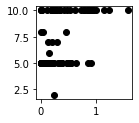

In [25]:
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
cor_ls = []

fig = plt.figure(figsize=(12,16))
# fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, j in enumerate(stn):
    merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
    merged.columns = ["Visibility", "AOD"]
    
    a=merged.dropna()
#     regression part
    slope, intercept, r_value, p_value, std_err = stats.linregress(list(a['AOD']),list(a['Visibility']))
    line = (slope*a['AOD'])+intercept
    
    # append correlation
    cor_ls.append([stn_lat[i], stn_lon[i], j, round(r_value, 2), round(p_value, 2)])
    
    ax = fig.add_subplot(8,6,i+1, )
    ax.scatter(merged['AOD'], merged['Visibility'], color = 'k')
    ax.plot(list(a['AOD']), line, 'r')
    title = j+': y={:.2f}x+{:.2f} \n '.format(slope,intercept)  + 'r={:.2f}, '.format(r_value) + 'p-value={:.2f}'.format(p_value)

    ax.set_title(title, fontsize = 10)
#     ax.set_xlim([0, 1.5])
    ax.set_ylim([-1, 11])
    
#     ax.set_ylabel('Visibility (in Km)')
#     ax.set_xlabel('bbb')
# fig.suptitle('a')
fig.supxlabel('AOD')
fig.supylabel('Visibility (in Km)')
fig.tight_layout(rect=(0.0,0,1,1))
    
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X")
# plt.ylabel("common Y")    
#     plt.subplot(7,7,i+1)
#     plt.scatter(merged['AOD'], merged['Visibility'], color = 'k', ls='solid')
#     plt.title(j)
# plt.xlabel('AOD')
# plt.ylabel('Visibility (in Km)')
#     plt.text(j)
#     for j in stn:
        
#         plt.subplot(2, 3, i)
#         plt.scatter(merged['AOD'], merged['Visibility'])
# # #         plt.text(0.5, 0.5, str((2, 3, i)),
# # #                  fontsize=18, ha='center')
            


# # fig = plt.figure(figsize=(3,3))
# fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(15,15))
# plt.subplots_adjust(hspace=0.2)
# for j, ax in zip(stn, axs.ravel()):
#     print(j, ax)
#     merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
#     merged.columns = ["Visibility", "AOD"]
# #     merged['AOD'].scatter(merged['Visibility'],ax=ax)
#     plt.scatter(merged['AOD'], merged['Visibility'],ax=ax)
# #     plt.figure()
# #     plt.scatter(merged['AOD'], merged['Visibility'],color='k', ls='solid')
# #     plt.show()
    
    

In [ ]:
cor_df = pd.DataFrame(cor_ls, columns=["Lat", "Long", "Station", "r_value", "p_value"])
cor_df['p'] = 2
cor_df.loc[cor_df['p_value'] > 0.05, 'p'] = 1
cor_df

In [ ]:
# cor_df.to_csv("cor_files/day1/ALADIN_1d.csv", index=False)
cor_df.to_csv("cor_files/day2/ALADIN_2d.csv", index=False)
# cor_df.to_csv("cor_files/day3/ALADIN_3d.csv", index=False)

In [ ]:
# plot coastlines with Basemap
plt.figure(figsize=(8, 8))
m = Basemap(projection='cyl', resolution='h',
llcrnrlat=3, urcrnrlat=15,
llcrnrlon=2, urcrnrlon=15)
# m.drawmapboundary(fill_color='#DDEEFF')
# m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='grey', zorder=2)
m.drawcountries(color='black', zorder=2)
# m.shadedrelief()
m.drawstates()

# m.readshapefile('./nigeria_states/nigeria_states', 'nigeria_states')

# plot locations
m.scatter(cor_df["Long"], cor_df["Lat"], latlon=True, 
          c=cor_df["r_value"], s=cor_df["p"]*100,
          edgecolors="black", zorder=3,
          cmap='jet', alpha=0.7)

# create colorbar and legend
m.colorbar(label=r'r', ticks=np.linspace(1, -1, 9), shrink=0.755)
# plt.set_ticks(np.linspace(1, -1, 9))
plt.xticks(range(2, 16, 2))
plt.yticks(range(3, 16, 2))
plt.show()